In [1]:
import glob
from skimage import io
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import random

from tqdm import tqdm_notebook as tqdm


from sklearn.model_selection import KFold


import sys
sys.path.insert(0, './code')
from evaluation import *
from training import *


import numpy as np
torch.manual_seed(1)
torch.cuda.manual_seed(1)
random.seed(1)
np.random.seed(2)

import pixiedust; 
# %%pixie_debugger

def set_seed(seed): 
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.RandomState(seed)
    torch.backends.cudnn.deterministic=True
    
idx2label = ["Bedroom", "Highway", "Kitchen", "Office", "Street", 
                        "Coast", "Industrial", "LivingRoom", "OpenCountry", "Suburb", 
                        "Forest", "InsideCity", "Mountain", "Store", "TallBuilding"]
classNames = idx2label

label2idx = {}
for i, label in enumerate(idx2label): 
    label2idx[label] = i 
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 1
# %%pixie_debugger

Pixiedust database opened successfully


cuda:0


In [2]:
assert torch.cuda.is_available()

print_every = 1
num_epoch = 100
K = 6
train_batch_size = 100
test_batch_size = 100
input_size = 124

In [3]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        depth1 = 2
        depth2 = depth1*2
        depth3 = depth2*2
        depth_out = 4

        # input size: 1 x 124 x 124 

        # 4 * 3 * 3 = 36 
        self.conv11 = nn.Conv2d(1, depth1, 3) # size - 2, 122
        self.bn11 = nn.BatchNorm2d(depth1) 

        # 4 * 3 * 3 * 4 = 144
        self.conv12 = nn.Conv2d(depth1, depth1, 3) # size - 2, 120
        self.bn12 = nn.BatchNorm2d(depth1)
        self.pool1 = nn.MaxPool2d(2, 2) # floor(size/2), 60

        # 4 * 3 * 3 * 8 = 288
        self.conv21 = nn.Conv2d(depth1, depth2, 3) # size - 2, 58
        self.bn21 = nn.BatchNorm2d(depth2)

        # 8 * 3 * 3 * 8 = 576
        self.conv22 = nn.Conv2d(depth2, depth2, 3) # size - 2, 56
        self.bn22 = nn.BatchNorm2d(depth2)
        self.pool2 = nn.MaxPool2d(2, 2) # floor(size/2), 28

        # 8 * 3 * 3 * 16 = 1152
        self.conv31 = nn.Conv2d(depth2, depth3, 3) # size - 2, 26
        self.bn31 = nn.BatchNorm2d(depth3)

        # 16 * 3 * 3 * 16 = 2304
        self.conv32 = nn.Conv2d(depth3, depth3, 3) # size - 2, 24
        self.bn32 = nn.BatchNorm2d(depth3)
        self.pool3 = nn.MaxPool2d(2, 2)  # floor(size/2), 12
        
        # output convolution layer
        self.convo = nn.Conv2d(depth3, depth_out, 1)
        self.bno = nn.BatchNorm2d(depth_out)
        

        self.hd0 = depth_out * 12 * 12 
        self.hd1 = 12 * 12
        self.hd2 = 50

        # 16*12*12 * 4*12*12 = 1327104
        self.fc1 = nn.Linear(self.hd0, self.hd1)
        self.bn_fc1 = nn.BatchNorm1d(self.hd1)

        # 4*12*12 * 4*12*12 = 331776 ? smaller
        self.fc2 = nn.Linear(self.hd1, self.hd2)
        self.bn_fc2 = nn.BatchNorm1d(self.hd2)

        # 4*12*12 * 15 = 8640
        self.out = nn.Linear(self.hd2, 15)

        self.act = torch.tanh


    def forward(self, x):

        x = self.bn11(self.act(self.conv11(x)))
        x = self.bn12(self.act(self.conv12(x)))
        x = self.pool1(x)

        x = self.bn21(self.act(self.conv21(x)))
        x = self.bn22(self.act(self.conv22(x)))
        x = self.pool2(x)

        x = self.bn31(self.act(self.conv31(x)))
        x = self.bn32(self.act(self.conv32(x)))
        x = self.pool3(x)
        
        x = self.bno(self.act(self.convo(x)))

        x = x.view(-1, self.hd0)
        x = self.bn_fc1(self.act(self.fc1(x)))
        x = self.bn_fc2(self.act(self.fc2(x)))
        x = self.out(x)

        return x

In [4]:
net = VGG()
print(net)
print("Total parameters = %d" % sum(p.numel() for p in net.parameters()))
print("Trainable parameters = %d" % sum(p.numel() for p in net.parameters() if p.requires_grad))

VGG(
  (conv11): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (bn11): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (bn12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
  (bn21): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (bn22): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn31): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn32): BatchNor

In [5]:
set_seed(SEED)
class SceneDataset(Dataset):
    def __init__(self, X_p, y, transform=None):
        self.transform = transform
        self.X_p = X_p
        self.y = y

    def __len__(self):
        return len(self.X_p)

    def __getitem__(self, idx):
        image = Image.open(self.X_p[idx]).convert('RGB')
        image = self.transform(image)
        
        return (image, self.y[idx])
    
    def show_item(self, idx): 
        item = self[idx]
        image = TF.to_pil_image(item[0])
        plt.imshow(image)
        plt.xlabel(classNames[item[1]])
        return image
        
train_tf = transforms.Compose([
     transforms.Resize(200),
     transforms.Grayscale(num_output_channels=1),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop((input_size, input_size)), 
     transforms.ToTensor(),    
     transforms.Normalize(
         mean=[0.5, 0.5, 0.5],
         std=[0.2, 0.2, 0.2])
])

test_tf = transforms.Compose([
    transforms.Resize(200),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomCrop((input_size, input_size)), 
    transforms.ToTensor(),    
    transforms.Normalize(
         mean=[0.5, 0.5, 0.5],
         std=[0.2, 0.2, 0.2])
])

def shuffle_list_pairs(a, b):
    combined = list(zip(a, b))
    random.shuffle(combined)
    a[:], b[:] = zip(*combined)

X_train_p = glob.glob("hw5/images/train/*/*")
y_train = [label2idx[s[17:].split("/")[0]] for s in X_train_p]

X_test_p = glob.glob("hw5/images/test/*/*")
y_test = [label2idx[s[16:].split("/")[0]] for s in X_test_p]

shuffle_list_pairs(X_train_p, y_train)
shuffle_list_pairs(X_test_p, y_test)

print("Train size = %d, test size = %d" %(len(X_train_p), len(X_test_p)))
print("Sampled Train Labels: ")
print(y_train[:10])
print("Sampled Test Labels: ")
print(y_test[:10])

Train size = 1500, test size = 2985
Sampled Train Labels: 
[7, 5, 7, 0, 1, 14, 10, 14, 8, 5]
Sampled Test Labels: 
[13, 4, 11, 10, 9, 3, 4, 9, 9, 13]


In [6]:
# %%pixie_debugger
def predict(net, dataloader, device): 
    y_hat = torch.LongTensor([])
    y_true = torch.LongTensor([])
    
    net.eval()
    for i, batch in enumerate(dataloader):     
        images, labels = batch
        images = images.to(device)
        labels = labels.to("cpu")

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
    
        predicted = predicted.to("cpu")

        y_true = torch.cat((y_true, labels), 0)
        y_hat = torch.cat((y_hat, predicted), 0)
    
    return (y_true, y_hat)

def evaluate(net, dataloader, classNames, device): 
    y_true, y_hat = predict(net, dataloader, device)
    return float((y_hat == y_true).sum())/len(y_true)

In [7]:
def _init_fn(worker_id):
    np.random.seed(1 + worker_id)
    
train_data = SceneDataset(X_train_p, y_train, transform=train_tf)
test_data = SceneDataset(X_test_p, y_test, transform=test_tf)

trainloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=4, worker_init_fn=_init_fn)
testloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, num_workers=4, worker_init_fn=_init_fn)

In [8]:
num_nets = 31
num_epoch = 100
pbar = tqdm(range(1, num_epoch+1))

nets = []
for i in range(num_nets): 
    set_seed(i)
    net = VGG()
    nets.append(net)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in range(num_nets): 
    print("Training network %d" % i)
    net = nets[i]
    net.to(device)

    # num_epoch = 10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    
    set_seed(i)
    train(net, criterion, optimizer, trainloader, device, num_epoch, print_every, pbar)
    
    net.to("cpu")
    nets[i] = net
    

Training network 0
[1/100] Loss = 2.54
[2/100] Loss = 2.29
[3/100] Loss = 2.05
[4/100] Loss = 1.91
[5/100] Loss = 1.81
[6/100] Loss = 1.76
[7/100] Loss = 1.70
[8/100] Loss = 1.66
[9/100] Loss = 1.64
[10/100] Loss = 1.64
[11/100] Loss = 1.69
[12/100] Loss = 1.70
[13/100] Loss = 1.61
[14/100] Loss = 1.60
[15/100] Loss = 1.57
[16/100] Loss = 1.59
[17/100] Loss = 1.60
[18/100] Loss = 1.54
[19/100] Loss = 1.54
[20/100] Loss = 1.57
[21/100] Loss = 1.51
[22/100] Loss = 1.53
[23/100] Loss = 1.53
[24/100] Loss = 1.52
[25/100] Loss = 1.50
[26/100] Loss = 1.50
[27/100] Loss = 1.52
[28/100] Loss = 1.57
[29/100] Loss = 1.51
[30/100] Loss = 1.48
[31/100] Loss = 1.47
[32/100] Loss = 1.47
[33/100] Loss = 1.47
[34/100] Loss = 1.46
[35/100] Loss = 1.47
[36/100] Loss = 1.46
[37/100] Loss = 1.48
[38/100] Loss = 1.44
[39/100] Loss = 1.43
[40/100] Loss = 1.50
[41/100] Loss = 1.42
[42/100] Loss = 1.50
[43/100] Loss = 1.48
[44/100] Loss = 1.44
[45/100] Loss = 1.47
[46/100] Loss = 1.42
[47/100] Loss = 1.43
[48

[87/100] Loss = 1.26
[88/100] Loss = 1.34
[89/100] Loss = 1.28
[90/100] Loss = 1.26
[91/100] Loss = 1.22
[92/100] Loss = 1.21
[93/100] Loss = 1.21
[94/100] Loss = 1.27
[95/100] Loss = 1.22
[96/100] Loss = 1.23
[97/100] Loss = 1.21
[98/100] Loss = 1.23
[99/100] Loss = 1.16
[100/100] Loss = 1.21
Finished Training
Training network 4
[1/100] Loss = 2.53
[2/100] Loss = 2.33
[3/100] Loss = 2.22
[4/100] Loss = 2.16
[5/100] Loss = 2.03
[6/100] Loss = 1.93
[7/100] Loss = 1.86
[8/100] Loss = 1.85
[9/100] Loss = 1.83
[10/100] Loss = 1.77
[11/100] Loss = 1.79
[12/100] Loss = 1.75
[13/100] Loss = 1.68
[14/100] Loss = 1.68
[15/100] Loss = 1.61
[16/100] Loss = 1.64
[17/100] Loss = 1.66
[18/100] Loss = 1.60
[19/100] Loss = 1.58
[20/100] Loss = 1.56
[21/100] Loss = 1.52
[22/100] Loss = 1.51
[23/100] Loss = 1.50
[24/100] Loss = 1.49
[25/100] Loss = 1.46
[26/100] Loss = 1.51
[27/100] Loss = 1.52
[28/100] Loss = 1.51
[29/100] Loss = 1.48
[30/100] Loss = 1.46
[31/100] Loss = 1.47
[32/100] Loss = 1.44
[33/1

[72/100] Loss = 1.39
[73/100] Loss = 1.39
[74/100] Loss = 1.44
[75/100] Loss = 1.37
[76/100] Loss = 1.34
[77/100] Loss = 1.42
[78/100] Loss = 1.41
[79/100] Loss = 1.37
[80/100] Loss = 1.35
[81/100] Loss = 1.35
[82/100] Loss = 1.35
[83/100] Loss = 1.37
[84/100] Loss = 1.39
[85/100] Loss = 1.43
[86/100] Loss = 1.39
[87/100] Loss = 1.37
[88/100] Loss = 1.37
[89/100] Loss = 1.33
[90/100] Loss = 1.32
[91/100] Loss = 1.32
[92/100] Loss = 1.32
[93/100] Loss = 1.36
[94/100] Loss = 1.39
[95/100] Loss = 1.28
[96/100] Loss = 1.35
[97/100] Loss = 1.31
[98/100] Loss = 1.33
[99/100] Loss = 1.28
[100/100] Loss = 1.35
Finished Training
Training network 8
[1/100] Loss = 2.54
[2/100] Loss = 2.33
[3/100] Loss = 2.25
[4/100] Loss = 2.13
[5/100] Loss = 2.11
[6/100] Loss = 2.00
[7/100] Loss = 1.93
[8/100] Loss = 1.80
[9/100] Loss = 1.74
[10/100] Loss = 1.69
[11/100] Loss = 1.67
[12/100] Loss = 1.65
[13/100] Loss = 1.63
[14/100] Loss = 1.59
[15/100] Loss = 1.58
[16/100] Loss = 1.58
[17/100] Loss = 1.59
[18/1

[57/100] Loss = 1.50
[58/100] Loss = 1.49
[59/100] Loss = 1.52
[60/100] Loss = 1.46
[61/100] Loss = 1.47
[62/100] Loss = 1.43
[63/100] Loss = 1.47
[64/100] Loss = 1.49
[65/100] Loss = 1.44
[66/100] Loss = 1.53
[67/100] Loss = 1.47
[68/100] Loss = 1.47
[69/100] Loss = 1.46
[70/100] Loss = 1.47
[71/100] Loss = 1.46
[72/100] Loss = 1.42
[73/100] Loss = 1.44
[74/100] Loss = 1.47
[75/100] Loss = 1.44
[76/100] Loss = 1.43
[77/100] Loss = 1.47
[78/100] Loss = 1.42
[79/100] Loss = 1.39
[80/100] Loss = 1.41
[81/100] Loss = 1.41
[82/100] Loss = 1.45
[83/100] Loss = 1.47
[84/100] Loss = 1.43
[85/100] Loss = 1.42
[86/100] Loss = 1.46
[87/100] Loss = 1.40
[88/100] Loss = 1.38
[89/100] Loss = 1.43
[90/100] Loss = 1.45
[91/100] Loss = 1.43
[92/100] Loss = 1.37
[93/100] Loss = 1.42
[94/100] Loss = 1.44
[95/100] Loss = 1.39
[96/100] Loss = 1.41
[97/100] Loss = 1.36
[98/100] Loss = 1.41
[99/100] Loss = 1.38
[100/100] Loss = 1.41
Finished Training
Training network 12
[1/100] Loss = 2.58
[2/100] Loss = 2.

In [9]:
def predict_ensemble(nets, testloader): 
    votes = torch.zeros(2985, 15)
    curr_id = 0
    y_true = None
    for i, net in enumerate(nets): 
        print("Predicting using net %d" % i)
        net.to("cuda:0")
        y_true, y_hat = predict(net, testloader, device)
        for i, y in enumerate(y_hat): 
            votes[i, y] = votes[i, y] + 1
    
    final_predict = torch.argmax(votes, 1)
    return (y_true, final_predict)

In [10]:
y_true, final_predict = predict_ensemble(nets, testloader)

Predicting using net 0
Predicting using net 1
Predicting using net 2
Predicting using net 3
Predicting using net 4
Predicting using net 5
Predicting using net 6
Predicting using net 7
Predicting using net 8
Predicting using net 9
Predicting using net 10
Predicting using net 11
Predicting using net 12
Predicting using net 13
Predicting using net 14


The accuracy is 0.65


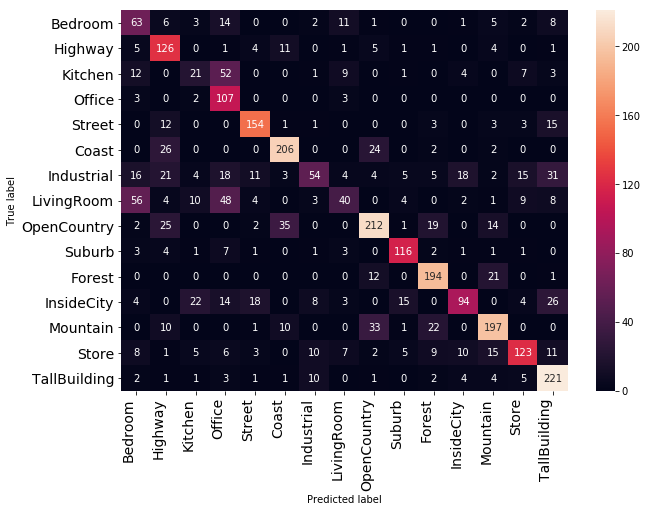

In [11]:
# %%pixie_debugger -b evaluate_cm
set_seed(SEED+2)

def test_cm(y_true, y_hat, classNames): 
    acc =  float((y_hat == y_true).sum())/len(y_true)
    plot_confusion_matrix(y_true, y_hat, classNames)
    print("The accuracy is %.2f" % acc)
test_cm(y_true, final_predict, classNames)